# Big Data Project: Flight Delay Prediction Using Spark Streaming & Kafka

In [2]:
import findspark

findspark.init()

In [3]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("FlightDataAnalysis").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/18 13:51:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read.csv("flight_data.csv", header=True, inferSchema=True)

df.show(5)


25/03/18 13:52:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+--------------------+--------------------+------------+--------+---------+------+-------------------+----+--------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|   FL_DATE|             AIRLINE|         AIRLINE_DOT|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|        ORIGIN_CITY|DEST|           DEST_CITY|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+----------+--------------------+--------------------+------------+--------+---------+------+-------------------+----+--------------------+------------+--------

In [5]:
df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

In [6]:
df.columns

['FL_DATE',
 'AIRLINE',
 'AIRLINE_DOT',
 'AIRLINE_CODE',
 'DOT_CODE',
 'FL_NUMBER',
 'ORIGIN',
 'ORIGIN_CITY',
 'DEST',
 'DEST_CITY',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'CANCELLED',
 'CANCELLATION_CODE',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'DELAY_DUE_CARRIER',
 'DELAY_DUE_WEATHER',
 'DELAY_DUE_NAS',
 'DELAY_DUE_SECURITY',
 'DELAY_DUE_LATE_AIRCRAFT']

In [7]:
import pyspark.sql.functions as F

In [11]:
[df.filter(df[col].isNull()).count() for col in df.columns]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 77615,
 77644,
 78806,
 78806,
 79944,
 79944,
 0,
 79942,
 86198,
 0,
 2920860,
 0,
 14,
 86198,
 86198,
 0,
 2466137,
 2466137,
 2466137,
 2466137,
 2466137]

In [13]:
# dropping crucial data for delays and then filling null delay causes with 0
df = df.dropna(subset=["ARR_DELAY", "DEP_DELAY"])
df = df.fillna({'DELAY_DUE_CARRIER': 0, 'DELAY_DUE_WEATHER': 0, 'DELAY_DUE_NAS': 0, 'DELAY_DUE_SECURITY': 0, 'DELAY_DUE_LATE_AIRCRAFT': 0})

In [16]:
# convert flight date to yyyy-MM-dd format
df = df.withColumn("FL_DATE", F.to_date(F.col("FL_DATE"), "yyyy-MM-dd"))

# Create new column to indicate severe delays
# can switch severity if needed
df = df.withColumn("SEVERE_DELAY", F.when(F.col("ARR_DELAY") >= 60, 1).otherwise(0))

df.select("FL_DATE", "AIRLINE", "ARR_DELAY", "SEVERE_DELAY").show(5)


+----------+--------------------+---------+------------+
|   FL_DATE|             AIRLINE|ARR_DELAY|SEVERE_DELAY|
+----------+--------------------+---------+------------+
|2019-01-09|United Air Lines ...|    -14.0|           0|
|2022-11-19|Delta Air Lines Inc.|     -5.0|           0|
|2022-07-22|United Air Lines ...|      0.0|           0|
|2023-03-06|Delta Air Lines Inc.|     24.0|           1|
|2020-02-23|    Spirit Air Lines|     -1.0|           0|
+----------+--------------------+---------+------------+
only showing top 5 rows



In [23]:
[df.filter(df[col].isNull()).count() for col in df.columns]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2913802,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [26]:
df = df.drop('CANCELLATION_CODE')

In [27]:
[df.filter(df[col].isNull()).count() for col in df.columns]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [32]:
df.columns

['FL_DATE',
 'AIRLINE',
 'AIRLINE_DOT',
 'AIRLINE_CODE',
 'DOT_CODE',
 'FL_NUMBER',
 'ORIGIN',
 'ORIGIN_CITY',
 'DEST',
 'DEST_CITY',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'CANCELLED',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'DELAY_DUE_CARRIER',
 'DELAY_DUE_WEATHER',
 'DELAY_DUE_NAS',
 'DELAY_DUE_SECURITY',
 'DELAY_DUE_LATE_AIRCRAFT',
 'SEVERE_DELAY']

# Encoding and Scaling

In [33]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler

In [36]:
df = df.drop(*['AIRLINE_DOT', 'DOT_CODE', 'FL_NUMBER'])

In [37]:
categorical_cols = ["AIRLINE", "ORIGIN", "DEST"]

indexers = [StringIndexer(inputCol = col, outputCol = col + "Index") for col in categorical_cols]

In [38]:
encoders = [OneHotEncoder(inputCol = col + "Index", outputCol=col + "OneHot") for col in categorical_cols]

In [39]:
numeric_cols = ["DEP_DELAY", "TAXI_OUT", "TAXI_IN", "ARR_DELAY", "DISTANCE",
                "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS",
                "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT"]


assembler = VectorAssembler(inputCols = numeric_cols, outputCol="features")

scaler = MinMaxScaler(inputCol = "features", outputCol = "scaled_features")

In [40]:
final_assembler = VectorAssembler(
    inputCols = ["AIRLINEOneHot", "ORIGINOneHot", "DESTOneHot", "scaled_features"],
    outputCol = "final_features"
)

In [41]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = indexers + encoders + [assembler, scaler, final_assembler])

In [42]:
processed_df = pipeline.fit(df).transform(df)

In [44]:
processed_df.select("final_features", "SEVERE_DELAY").show(5)

+--------------------+------------+
|      final_features|SEVERE_DELAY|
+--------------------+------------+
|(785,[4,40,414,77...|           0|
|(785,[1,30,404,77...|           0|
|(785,[4,20,409,77...|           0|
|(785,[1,30,410,77...|           1|
|(785,[11,26,397,7...|           0|
+--------------------+------------+
only showing top 5 rows



# Visualization

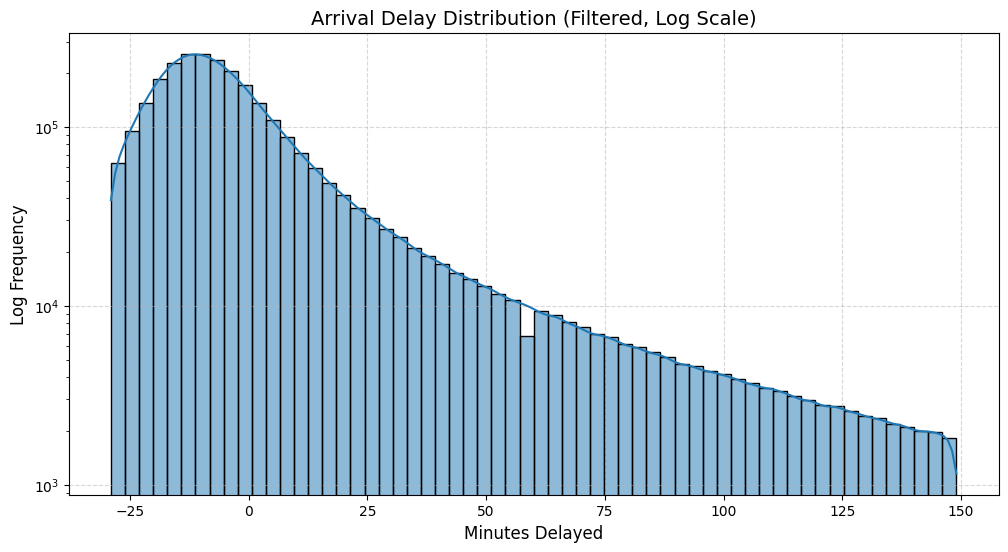

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas
pd_df = df.select("ARR_DELAY").toPandas()

pd_df_filtered = pd_df[(pd_df["ARR_DELAY"] > -30) & (pd_df["ARR_DELAY"] < 150)]

plt.figure(figsize=(12, 6))
sns.histplot(pd_df_filtered["ARR_DELAY"].dropna(), bins=60, kde=True)

plt.yscale("log")

plt.title("Arrival Delay Distribution (Filtered, Log Scale)", fontsize=14)
plt.xlabel("Minutes Delayed", fontsize=12)
plt.ylabel("Log Frequency", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


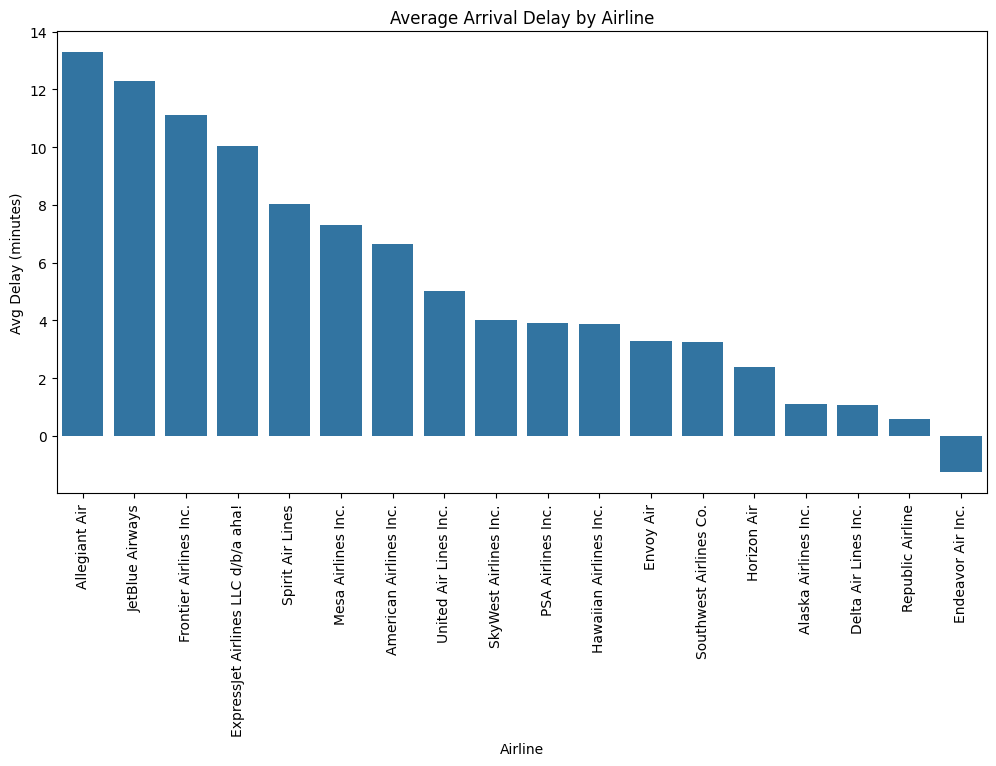

In [21]:
airline_delays = df.groupBy("AIRLINE").agg(F.avg("ARR_DELAY").alias("AvgArrDelay")).toPandas()

airline_delays = airline_delays.sort_values("AvgArrDelay", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="AIRLINE", y="AvgArrDelay", data=airline_delays)
plt.xticks(rotation=90)
plt.title("Average Arrival Delay by Airline")
plt.xlabel("Airline")
plt.ylabel("Avg Delay (minutes)")
plt.show()


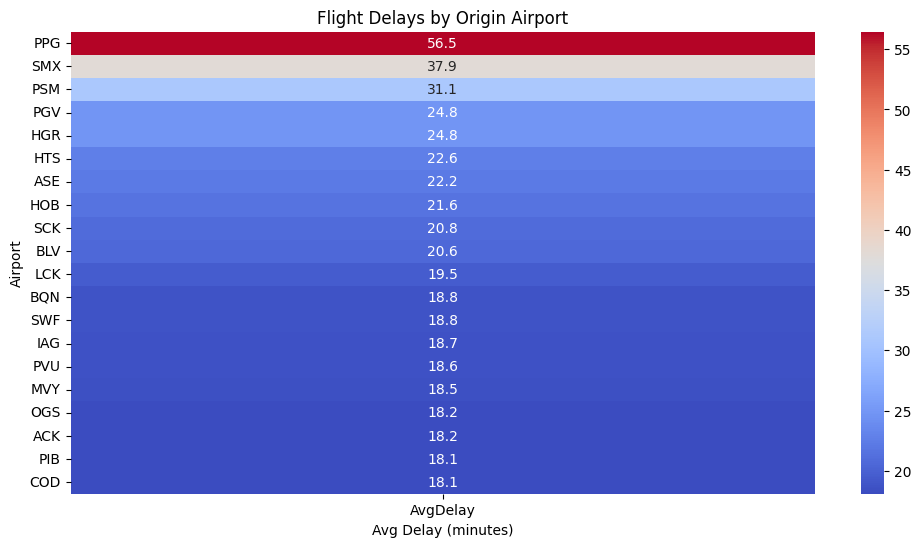

In [28]:
airport_delays = df.groupBy("ORIGIN").agg(F.avg("ARR_DELAY").alias("AvgDelay")).toPandas()
airport_delays = airport_delays.sort_values("AvgDelay", ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.heatmap(airport_delays.set_index("ORIGIN"), cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Flight Delays by Origin Airport")
plt.xlabel("Avg Delay (minutes)")
plt.ylabel("Airport")
plt.show()


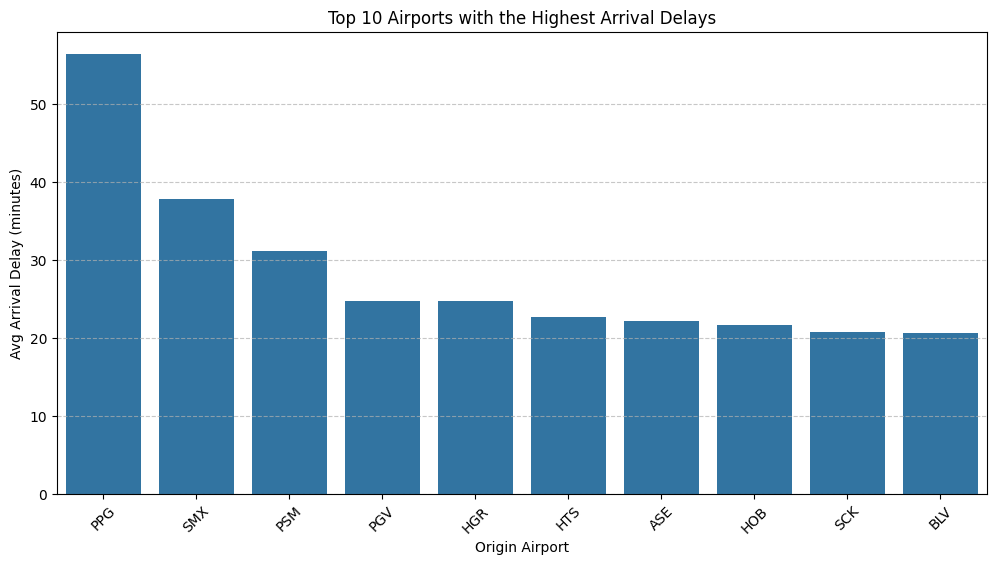

In [31]:
airport_delays = df.groupBy("ORIGIN").agg(F.avg("ARR_DELAY").alias("AvgDelay")).toPandas()
airport_delays_top10 = airport_delays.sort_values("AvgDelay", ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x="ORIGIN", y="AvgDelay", data=airport_delays_top10)

plt.xticks(rotation=45)
plt.title("Top 10 Airports with the Highest Arrival Delays")
plt.xlabel("Origin Airport")
plt.ylabel("Avg Arrival Delay (minutes)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()
